|序号|变量名称|描述|
|------------|-------------|----------------------|
| 1 | 城市 | 房屋所在城市 |
| 2 | 区域 | 房屋所在县/市/区 |
| 3 | 板块 | 房屋所在板块（城市、区域、板块为包含关系） |
| 4 | 环线 | 房屋相对于城市重要环线/主干道路的位置 |
| 5 | 小区名称 | 房屋所属小区名称 |
| 6 | 价格 | 房屋成交价格 |
| 7 | 房屋户型 | 房屋户型（包含卧室数量、客厅数量、厨房数量、卫生间数量等信息） |
| 8 | 所在楼层 | 房屋所在楼层（包含总楼层信息） |
| 9 | 建筑面积 | 房屋建筑面积（套内面积+公摊面积） |
| 10 | 套内面积 | 房屋套内面积 |
| 11 | 房屋朝向 | 房屋朝向（存在多朝向房屋） |
| 12 | 建筑结构 | 房屋建筑主体构造 |
| 13 | 装修情况 | 房屋交易时装修情况 |
| 14 | 梯户比例 | 电梯数量与每层住户数量比例 |
| 15 | 配备电梯 | 楼层是否配备电梯 |
| 16 | 别墅类型 | 别墅的建筑风格和建筑形式（非别墅房屋为空值） |
| 17 | 交易时间 | 房屋成交时间 |
| 18 | 交易权属 | 房屋交易权属（商品房，已购公房等） |
| 19 | 上次交易 | 上次交易时间 |
| 20 | 房屋用途 | 房屋用途（普通住宅，商用住宅，商住两用等） |
| 21 | 房屋年限 | 房屋首次购买过户到交易时间年限 |
| 22 | 产权所属 | 房屋所有权人（共有、非） |
| 23 | 抵押信息 | 房屋抵押信息（是否用于抵押贷款等，无抵押信息为空） |
| 24 | 房屋优势 | 自然语言描述，针对房屋总体优势进行总结 |
| 25 | 核心卖点 | 自然语言描述，针对房屋卖点进行详细描述 |
| 26 | 户型介绍 | 自然语言描述，针对户型、朝向、楼层等信息进行描述 |
| 27 | 周边配套 | 自然语言描述，针对房屋周边商场、学校、医院等描述 |
| 28 | 交通出行 | 自然语言描述，针对房屋周边交通情况描述，包括地铁、公交、主干道等 |
| 29 | lon | 房屋所在经度 |
| 30 | lat | 房屋所在维度 |
| 31 | 年份 | 房屋登记时间 |

In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_file = 'ruc_Class25Q1_train.csv'
test_file = 'ruc_Class25Q1_test.csv'
train_df = pd.read_csv(train_file)
train_df['ID'] = -1
test_df = pd.read_csv(test_file)
test_df = test_df.drop(columns=['抵押信息'])
df = pd.concat([train_df, test_df], ignore_index=True) 
df = df.drop(['Unnamed: 0'], axis=1)
df.shape

(98919, 31)

In [283]:
def class2onehot(df,col):
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    dropped_col = df[col]
    df.drop(col, axis=1, inplace=True)
    # 防止多重共线性
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, dropped_col
chinese2num_dict = {
    '一': 1,
    '二': 2,
    '两': 2,
    '三': 3,
    '四': 4,
    '五': 5,
    '六': 6,
    '七': 7,
    '八': 8,
    '九': 9,
    '十': 10,
    '十一': 11,
    '十二': 12,
    '十三': 13,
    '十四': 14,
    '十五': 15,
    '十六': 16,
    '十七': 17,
    '十八': 18,
    '十九': 19,
    '二十': 20,
    '二十一': 21,
    '二十二': 22,
    '二十三': 23,
    '二十四': 24,
    '二十五': 25,
    '二十六': 26,
    '二十七': 27,
    '二十八': 28,
    '二十九': 29,
    '三十': 30,
    '三十一': 31,
    '三十二': 32,
    '三十三': 33,
    '三十四': 34,
    '三十五': 35,
    '三十六': 36,
    '三十七': 37,
    '三十八': 38,
    '三十九': 39,
    '四十': 40,
    '四十一': 41,
    '四十二': 42,
    '四十三': 43,
    '四十四': 44,
    '四十五': 45,
    '四十六': 46,
    '四十七': 47,
    '四十九': 49,
    '五十': 50,
    '五十一': 51,
    '五十二': 52,
    '五十三': 53,
    '五十四': 54,
    '五十五': 55,
    '五十六': 56,
    '五十七': 57,
    '五十八': 58,
    '五十九': 59,
    '六十': 60,
    '六十一': 61,
    '六十二': 62,
    '六十三': 63,
    '六十四': 64,
    '六十五': 65,
    '六十六': 66,
    '六十七': 67,
    '六十八': 68,
    '六十九': 69,
    '七十': 70,
    '七十一': 71,
    '七十二': 72,
    '七十三': 73,
    '七十四': 74,
    '七十五': 75,
    '七十六': 76,
    '七十七': 77,
    '七十八': 78,
    '七十九': 79,
    '八十': 80,
    '八十一': 81,
    '八十二': 82,
    '八十三': 83,
    '八十四': 84,
    '八十五': 85,
    '八十六': 86,
    '八十七': 87,
    '八十八': 88,
    '八十九': 89,
    '九十': 90,
    '九十一': 91,
    '九十二': 92,
    '九十三': 93,
    '九十四': 94,
    '九十五': 95,
    '九十六': 96,
    '九十七': 97,
    '九十八': 98,
    '九十九': 99,
    '一百': 100
    }

1、城市：
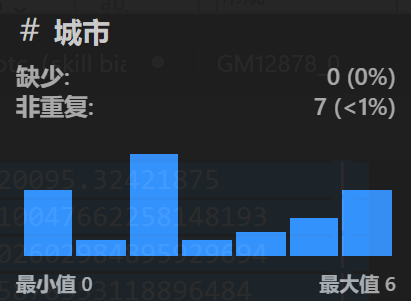

In [284]:
df ,city_col= class2onehot(df,'城市')
df = pd.concat([df, city_col], axis=1)
df.shape

(98919, 37)

2~3、区域、板块：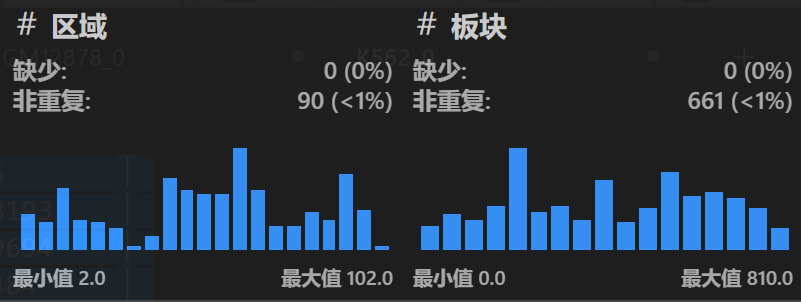

In [285]:
df = df.drop(['区域','板块'], axis=1)

4、环线：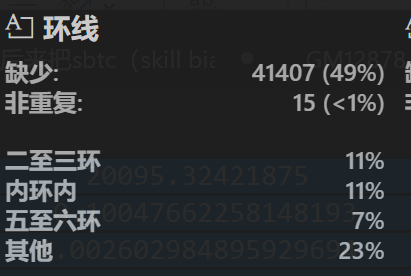

In [286]:
# print(df['环线'].unique())
# ['二至三环' '五至六环' '三至四环' '四至五环' '六环外' nan '二环内' '内环内' '内环至外环' '外环外' '中环至外环' '内环至中环' '一至二环' '一环内' '四环外' '三环外']
line2num_dict = {
    '二至三环': 2,
    '五至六环': 5,
    '三至四环': 3,
    '四至五环': 4,
    '六环外': 6,
    '二环内': 2,
    '内环内': 1,
    '内环至外环': 0,
    '外环外': 7,
    '中环至外环': 8,
    '内环至中环': 9,
    '一至二环': 1,
    '一环内': 0,
    '四环外': 4,
    '三环外': 3
}
df['环线'] = df['环线'].map(line2num_dict)

5、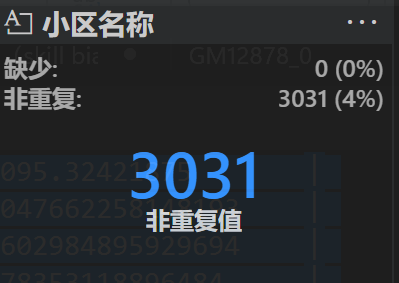

In [287]:
df =df.drop(['小区名称'], axis=1)

6、价格：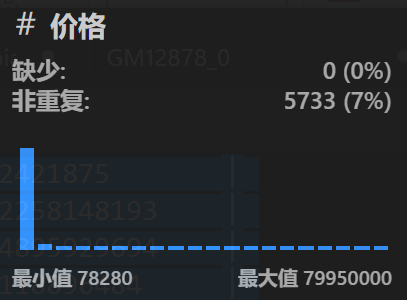

In [288]:
df = df[(df['价格'] < 16000000) | (df['价格'].isnull())]  # 剔除价格异常值,但是保留空值
df.shape

(98467, 34)

7、户型：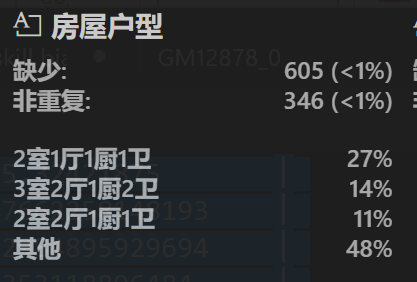

In [289]:
# 室、厅、厨、卫、房间
df['室'] = df['房屋户型'].apply(lambda x:int(x.split('室')[0]) if '室' in str(x) else 0)
df['厅'] = df['房屋户型'].apply(lambda x:int(x.split('厅')[0].split('室')[-1]) if '厅' in str(x) else 0)
df['厨'] = df['房屋户型'].apply(lambda x:int(x.split('厨')[0].split('厅')[-1]) if '厨' in str(x) else 0)
def process1(x):
    if '卫' in str(x):
        if '厨' in str(x):
            return int(x.split('卫')[0].split('厨')[-1])
        else:  # 4房间2卫
            return int(x.split('卫')[0].split('房间')[-1])
    else:
        return 0
def process2(x):
    if '房间' in str(x):
        if '卫' in str(x): # 4房间2卫
            return int(x.split('房间')[0])
        # else:
        #     return int(x.split('卫')[0].split('厅')[-1])
    else:
        return 0
df['卫'] = df['房屋户型'].apply(process1)
df['房间'] = df['房屋户型'].apply(lambda x:int(x.split('房间')[0]) if '房间' in str(x) else 0)
df = df.drop('房屋户型',axis=1)

8、所在楼层：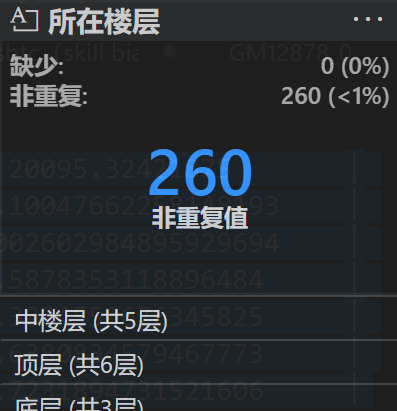

In [290]:
import re
# print(df['所在楼层'].unique())
floor_mapping = {
    '低楼层': 1,
    '中楼层': 2,
    '高楼层': 3,
    '顶层': 4,
    '底层': 0,
    '地下室': -1
}
def process_floor(floor_str):
    # 提取楼层位置
    floor_position = re.search(r'(低楼层|中楼层|高楼层|顶层|底层|地下室)', floor_str)
    position_value = floor_mapping[floor_position.group()] if floor_position else None
    
    # 提取总楼层数
    total_floors = re.search(r'共(\d+)层', floor_str)
    total_floors_value = int(total_floors.group(1)) if total_floors else None
    
    return position_value, total_floors_value
# 应用到数据框
df[['楼层位置encode', '总楼层数']] = df['所在楼层'].apply(lambda x: pd.Series(process_floor(x)))
df,_ = class2onehot(df,'楼层位置encode')
df = df.drop(['所在楼层'], axis=1)

9~10、建筑面积+套内面积：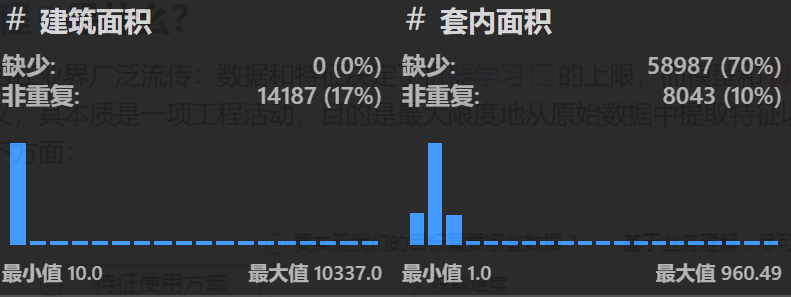

(array([2.370e+02, 1.260e+02, 2.010e+02, 8.270e+02, 1.623e+03, 2.653e+03,
        4.053e+03, 5.105e+03, 5.300e+03, 4.979e+03, 4.924e+03, 5.875e+03,
        6.770e+03, 8.063e+03, 7.223e+03, 6.505e+03, 4.151e+03, 3.485e+03,
        3.733e+03, 3.318e+03, 3.317e+03, 2.806e+03, 2.699e+03, 2.120e+03,
        1.250e+03, 1.092e+03, 8.230e+02, 7.010e+02, 5.500e+02, 3.640e+02,
        4.390e+02, 3.170e+02, 2.960e+02, 2.360e+02, 2.350e+02, 1.670e+02,
        1.600e+02, 1.300e+02, 1.350e+02, 1.350e+02, 1.110e+02, 7.500e+01,
        8.900e+01, 4.800e+01, 5.200e+01, 5.300e+01, 1.110e+02, 1.040e+02,
        5.700e+01, 5.000e+01, 4.600e+01, 7.600e+01, 3.800e+01, 2.800e+01,
        1.900e+01, 8.000e+00, 2.600e+01, 1.700e+01, 1.300e+01, 7.000e+00,
        2.100e+01, 1.600e+01, 2.200e+01, 1.900e+01, 1.200e+01, 2.300e+01,
        3.300e+01, 1.500e+01, 1.900e+01, 4.000e+00, 7.000e+00, 1.600e+01,
        1.800e+01, 6.000e+00, 4.000e+00, 9.000e+00, 1.100e+01, 6.000e+00,
        3.000e+00, 2.000e+00, 6.000e+0

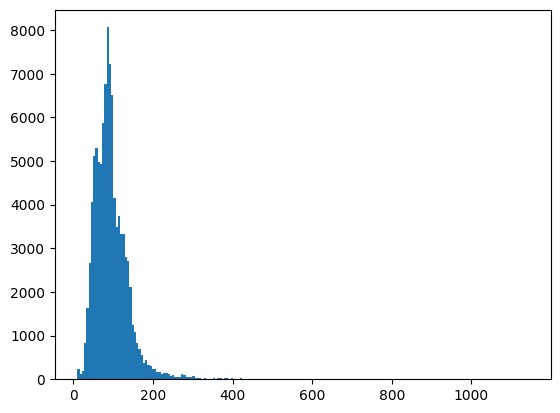

In [291]:
df=df[df['建筑面积']<1200]
plt.hist(df['建筑面积'],bins=200)

11、房屋朝向：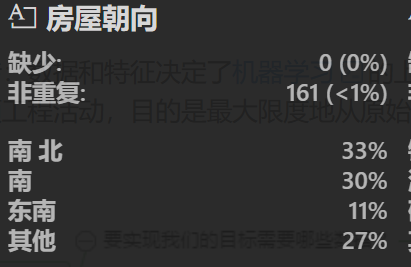

In [292]:
df['east'] = df['房屋朝向'].apply(lambda x: 1 if '东' in x else 0)
df['west'] = df['房屋朝向'].apply(lambda x: 1 if '西' in x else 0)
df['south'] = df['房屋朝向'].apply(lambda x: 1 if '南' in x else 0)
df['north'] = df['房屋朝向'].apply(lambda x: 1 if '北' in x else 0)
df.drop('房屋朝向', axis=1, inplace=True)

12~13、建筑结构+装修情况：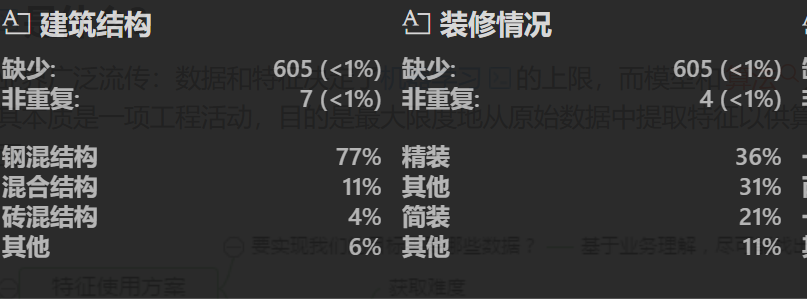

In [293]:
df,_ = class2onehot(df,'装修情况')
df,_ = class2onehot(df,'建筑结构')

14~16、梯户比例+配备电梯+别墅类型：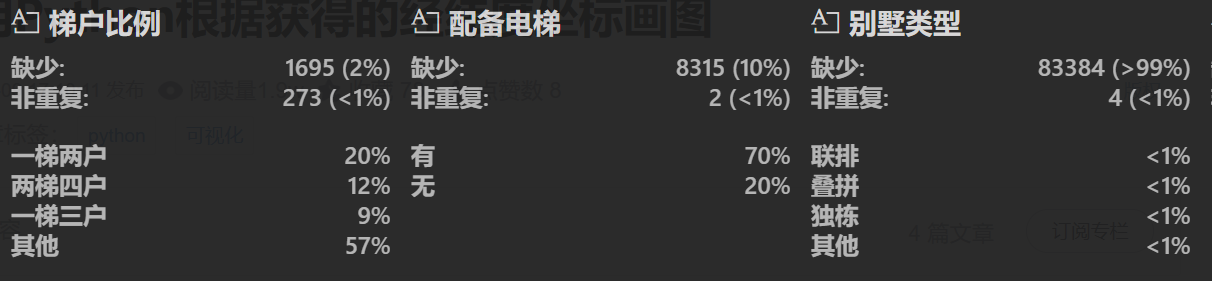

In [294]:
df['lift_ratio'] = df['梯户比例'].apply(lambda x:
                                    chinese2num_dict[x.split('梯')[0]]/chinese2num_dict[x.split('梯')[1].replace('户','')]
                                    if '梯' in str(x) else 0)
df = df.drop('梯户比例',axis=1)
df,_ = class2onehot(df,'配备电梯')
# 如果别墅类型为缺失值，就是0，否则是1
df['别墅类型'] = df['别墅类型'].apply(lambda x: 0 if pd.isnull(x) else 1)

17+19+31、交易时间+上次交易+年份：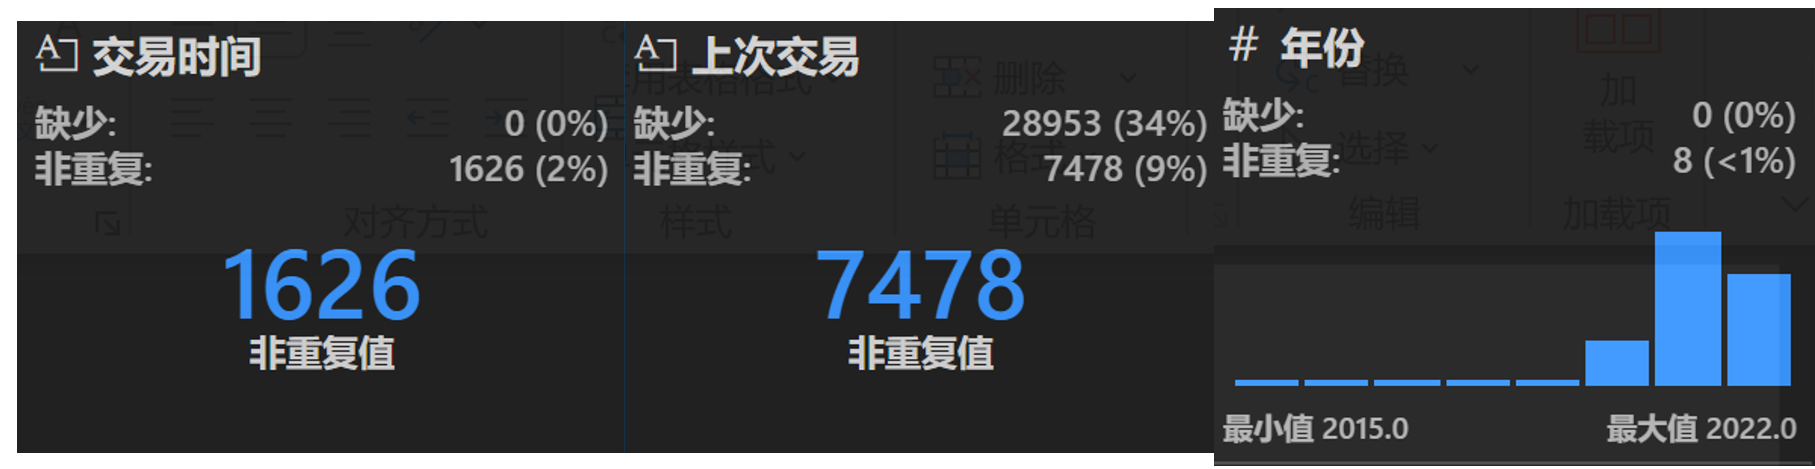

In [295]:
# drop 交易时间+上次交易+年份
list_drop = ['交易时间','上次交易','年份']
df = df.drop(list_drop,axis=1)

18+20+21：交易权属+房屋用途+房屋年限：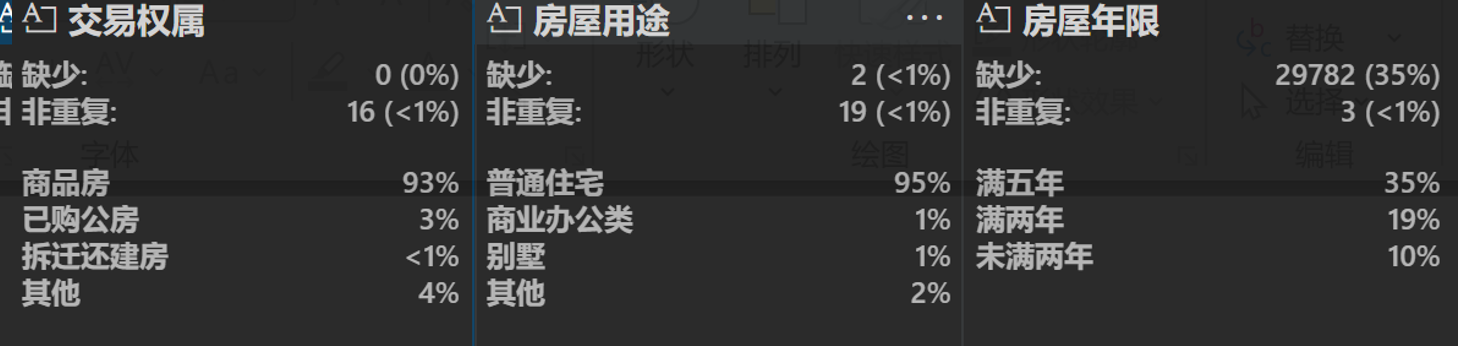

In [296]:
# drop 交易权属+房屋用途+房屋年限
list_drop = ['交易权属','房屋用途']
df = df.drop(list_drop,axis=1)
df,_ = class2onehot(df,'房屋年限')

22+23：产权所属+抵押信息：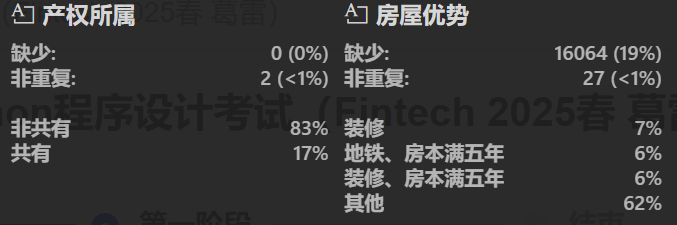

In [297]:
df,_ = class2onehot(df,'产权所属')

24~28：房屋优势+核心卖点+户型介绍+周边配套+交通出行：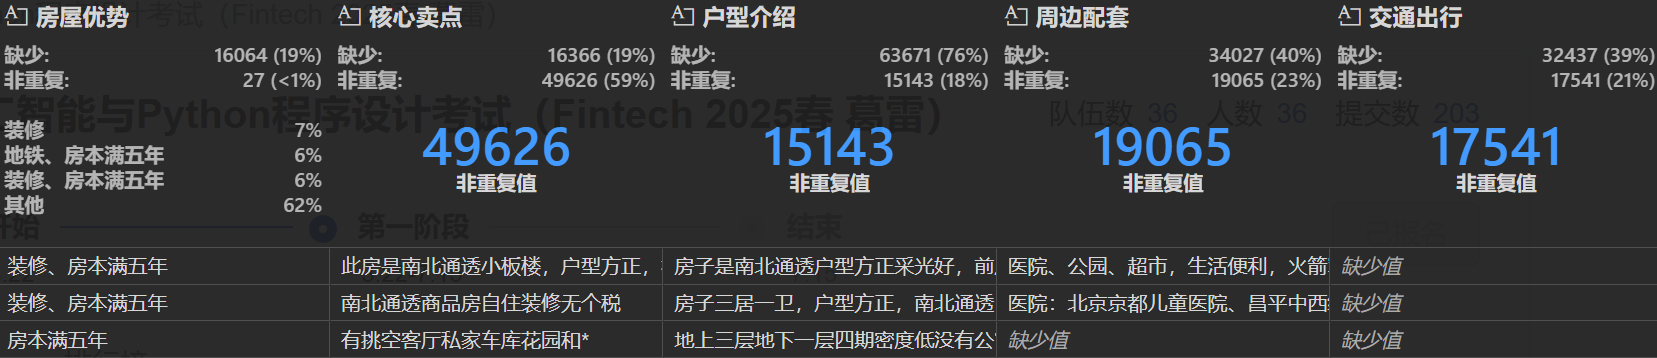

In [298]:
# 地铁、装修、房本满两年、房本满五年
# print(df['房屋优势'].unique()) 
'''['装修、房本满五年' '房本满五年' '地铁、房本满五年、' '地铁、房本满五年' '地铁、房本满两年' '、房本满五年' '房本满五年、'
 '装修、房本满两年' '房本满两年、' '装修、房本满两年、' '地铁、装修、房本满五年、' '地铁、装修、房本满五年' '、房本满两年'
 '装修、房本满五年、' '、房本满两年、' '地铁、装修、房本满两年' '房本满两年' '地铁、装修、房本满两年、' '地铁、房本满两年、'
 '、房本满五年、' nan '地铁、装修' '地铁、装修、' '地铁、' '装修' '装修、' '地铁' '、']'''
df['房屋优势'] = df['房屋优势'].fillna('')
df['地铁'] = df['房屋优势'].apply(lambda x: 1 if '地铁' in x else 0)
df['装修'] = df['房屋优势'].apply(lambda x: 1 if '装修' in x else 0)
df['房本满两年'] = df['房屋优势'].apply(lambda x: 1 if '满两年' in x else 0)
df['房本满五年'] = df['房屋优势'].apply(lambda x: 1 if '满五年' in x else 0)
df =df.drop('房屋优势',axis=1)

In [299]:
# drop房屋优势+核心卖点+户型介绍+周边配套+交通出行
list_drop = ['核心卖点','户型介绍','周边配套','交通出行']
df = df.drop(list_drop,axis=1)

29~30：lon+lat：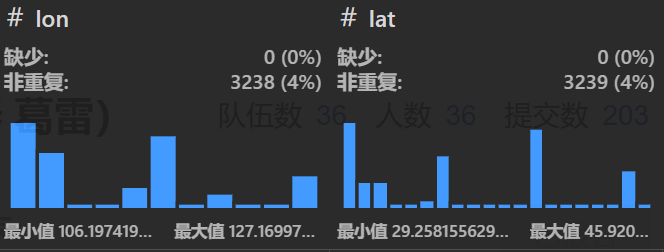

/home/duanyi_prv/anaconda3/envs/ES/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/duanyi_prv/anaconda3/envs/ES/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/duanyi_prv/anaconda3/envs/ES/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/duanyi_prv/anaconda3/envs/ES/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


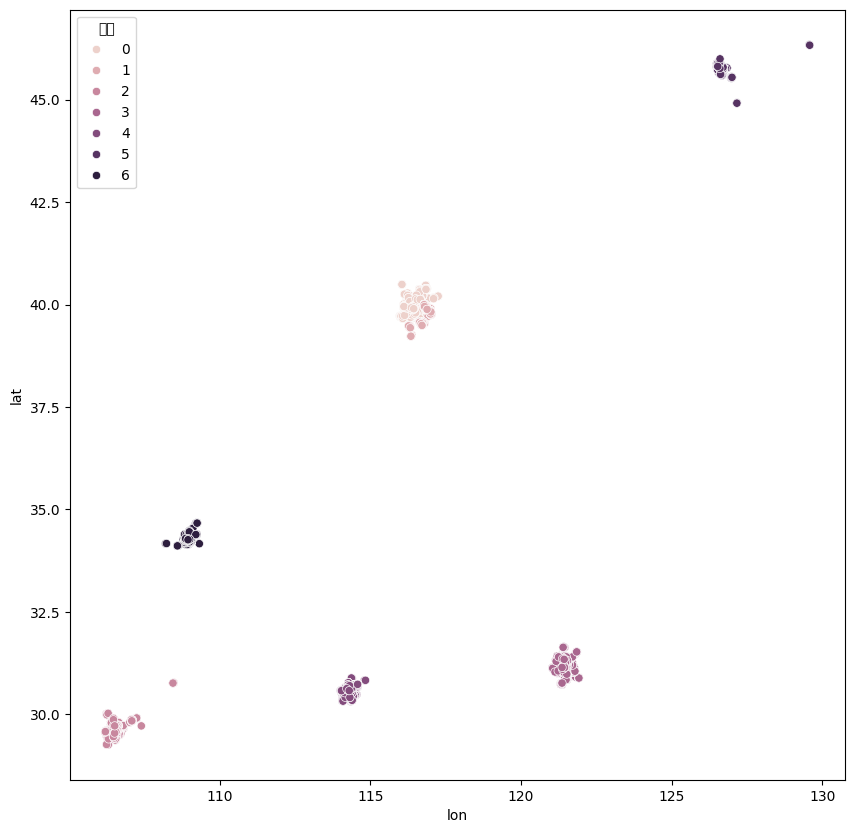

In [300]:
# 按城市分组计算经纬度的均值，并进行处理
plt.figure(figsize=(10, 10))
sns.scatterplot(x='lon', y='lat', data=df, hue='城市')
df['lat2central'] = df.groupby('城市')['lat'].transform(lambda x: (x - x.mean())**2/ x.std())
df['lon2central'] = df.groupby('城市')['lon'].transform(lambda x: (x - x.mean())**2/ x.std())
df.drop(['lat','lon'],axis=1,inplace=True)

In [301]:
# 除了价格全部用中位数填充
for col in df.columns:
    if col != '价格':
        df[col] = df[col].fillna(df[col].median())
for col in df.columns:
    print(col,len(df[col].unique()),df[col].dtype)

环线 10 float64
价格 5513 float64
建筑面积 14534 float64
套内面积 8428 float64
别墅类型 2 int64
ID 14787 int64
城市_0 2 bool
城市_1 2 bool
城市_2 2 bool
城市_3 2 bool
城市_4 2 bool
城市_5 2 bool
城市 7 int64
室 15 int64
厅 7 int64
厨 5 int64
卫 11 int64
房间 9 int64
总楼层数 58 int64
楼层位置encode_-1 2 bool
楼层位置encode_0 2 bool
楼层位置encode_1 2 bool
楼层位置encode_2 2 bool
楼层位置encode_3 2 bool
east 2 int64
west 2 int64
south 2 int64
north 2 int64
装修情况_其他 2 bool
装修情况_毛坯 2 bool
装修情况_简装 2 bool
建筑结构_未知结构 2 bool
建筑结构_框架结构 2 bool
建筑结构_混合结构 2 bool
建筑结构_砖木结构 2 bool
建筑结构_砖混结构 2 bool
建筑结构_钢混结构 2 bool
lift_ratio 171 float64
配备电梯_无 2 bool
房屋年限_未满两年 2 bool
房屋年限_满两年 2 bool
产权所属_共有 2 bool
地铁 2 int64
装修 2 int64
房本满两年 2 int64
房本满五年 2 int64
lat2central 3470 float64
lon2central 3473 float64


In [302]:
# 查找nan
nan_list = []
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col,df[col].isnull().sum())

价格 14786


# 拟合

In [305]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 移除异常值（假设价格列中移除大于 3 倍标准差的异常值）
# df = df[np.abs(df['价格'] - df['价格'].mean()) <= (3 * df['价格'].std())]

# 拆分数据集
train_df = df[df['ID'] == -1]
pred_df = df[df['ID'] != -1]

X = train_df.drop(['价格', 'ID'], axis=1)
y = train_df['价格']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义模型
models = {
    'OLS': LinearRegression(),
    'LASSO': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0)
}

# 初始化结果表
results = []

# 遍历模型
for name, model in models.items():
    # 训练模型
    model.fit(X_train, y_train)
    
    # In-sample 预测
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    
    # Out-of-sample 预测
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Cross-validation
    cv_results = cross_validate(model, X, y, cv=6, scoring='neg_mean_absolute_error', return_train_score=True)
    cv_mae = -np.mean(cv_results['test_score'])
    cv_rmse = np.sqrt(-np.mean(cv_results['test_score']))
    # predict
    y_pred = model.predict(pred_df.drop(['价格', 'ID'], axis=1))
    result_df = pd.DataFrame({
    'ID': pred_df['ID'],
    'Price': y_pred
    })
    result_df.to_csv(f'./{name}_predictions.csv', index=False, float_format='%.4f')
    
    # 保存结果
    results.append({
        'Model': name,
        'In-sample MAE': train_mae,
        'In-sample RMSE': train_rmse,
        'Out-of-sample MAE': test_mae,
        'Out-of-sample RMSE': test_rmse,
        'Cross-validation MAE': cv_mae,
        'Cross-validation RMSE': cv_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果表
print(results_df)

# 统计总预测数量
total_predictions = len(pred_df)
print("Total predictions after removing outliers:", total_predictions)

/home/duanyi_prv/anaconda3/envs/ES/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e+15, tolerance: 2.797e+13
  model = cd_fast.enet_coordinate_descent(
/home/duanyi_prv/anaconda3/envs/ES/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.647e+15, tolerance: 1.560e+13
  model = cd_fast.enet_coordinate_descent(
/home/duanyi_prv/anaconda3/envs/ES/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

   Model  In-sample MAE  In-sample RMSE  Out-of-sample MAE  \
0    OLS  676386.527515    1.097210e+06      674012.897281   
1  LASSO  676386.272507    1.097210e+06      674012.642750   
2  Ridge  676331.870630    1.097210e+06      673962.521396   

   Out-of-sample RMSE  Cross-validation MAE  Cross-validation RMSE  
0        1.095956e+06          2.477804e+15           4.977754e+07  
1        1.095956e+06          9.120133e+05           9.549939e+02  
2        1.095968e+06          9.667729e+05           9.832461e+02  
Total predictions after removing outliers: 14786


In [307]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 创建 LGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置 LGBM 参数
params = {
    'objective': 'regression',  # 回归任务
    'metric': 'rmse',          # 使用 RMSE 作为评估指标
    'boosting_type': 'gbdt',   # 使用梯度提升决策树
    'learning_rate': 0.1,      # 学习率
    'num_leaves': 31,          # 叶子节点数
    'max_depth': -1,           # 不限制树的深度
    'feature_fraction': 0.8,   # 每次迭代使用的特征比例
    'bagging_fraction': 0.8,   # 每次迭代使用的数据比例
    'bagging_freq': 5,         # 每 5 次迭代进行一次 bagging
    'verbose': -1              # 不输出日志
}

# 训练模型
lgbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=800,       # 最大迭代次数
    valid_sets=[train_data, test_data],  # 验证集
    # early_stopping_rounds=50    # 提前停止
)

# 预测
y_train_pred = lgbm_model.predict(X_train, num_iteration=lgbm_model.best_iteration)
y_test_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# 评估模型性能
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}")
# predict
y_pred = lgbm_model.predict(pred_df.drop(['价格', 'ID'], axis=1))
result_df = pd.DataFrame({
    'ID': pred_df['ID'],
    'Price': y_pred
})
result_df.to_csv(f'./LGBM_predictions.csv', index=False, float_format='%.4f')

Train MAE: 150694.6911, Train RMSE: 245720.6123
Test MAE: 188713.3728, Test RMSE: 359419.2900


 Model  In-sample MAE  In-sample RMSE  Out-of-sample MAE  \
0    OLS  676386.527515    1.097210e+06      674012.897281   
1  LASSO  676386.272507    1.097210e+06      674012.642750   
2  Ridge  676331.870630    1.097210e+06      673962.521396   

   Out-of-sample RMSE  Cross-validation MAE  Cross-validation RMSE  
0        1.095956e+06          2.477804e+15           4.977754e+07  
1        1.095956e+06          9.120133e+05           9.549939e+02  
2        1.095968e+06          9.667729e+05           9.832461e+02  
Total predictions after removing outliers: 14786